In [1]:
from vizdoom import *
import random
import time
import numpy as np
import os

In [11]:
print(vizdoom.__version__)

1.2.4


# SETUP-GAME

In [12]:
game = DoomGame()
game.load_config(r'./scenarios/basic.cfg')
game.init()

## BASIC
The purpose of the scenario is just to check if using this framework to train some AI in a 3D environment is feasible.

The map is a rectangle with gray walls, ceiling, and floor. The player is spawned along the longer wall in the center. A red, circular monster is spawned randomly somewhere along the opposite wall. A player can only (config) go left/right and shoot. 1 hit is enough to kill the monster. The episode finishes when the monster is killed or on timeout.

### REWARDS:

+106 for killing the monster

-5 for every shot

+1 for every tic the agent is alive

The episode ends after killing the monster or on timeout.

### CONFIGURATION:

3 available buttons: move left/right, shoot (attack)

1 available game variable: player’s ammo

timeout = 300 tics

Gymnasium/Gym id: "VizdoomBasic-v0"

`Configuration file: basic.cfg`

In [7]:
actions = np.identity(3, dtype=np.uint8)
print(actions)

[[1 0 0]
 [0 1 0]
 [0 0 1]]


1. actions[0] : MOVE_LEFT
2. actions[1] : MOVE_RIGHT
3. actions[2] : ATTACK

In [14]:
game.new_episode()
game.is_episode_finished()
game.make_action(random.choice(actions))

-1.0

In [15]:
episodes = 3
for e in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        satate=game.get_state()
        state = game.get_state()
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4) # frame skip=4 time for agent to process
        print('reward:', reward) 
        print("ammo",info)
        print("state",state)
        time.sleep(0.02)
    print('////////////////// Result:', game.get_total_reward())
    time.sleep(2)

reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FEB30>
reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC5B0>
reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC170>
reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FEB30>
reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC5B0>
reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC170>
reward: -4.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC230>
reward: -9.0
ammo [50.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC5B0>
reward: -4.0
ammo [49.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC170>
reward: -4.0
ammo [49.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC230>
reward: -4.0
ammo [49.]
state <vizdoom.vizdoom.GameState object at 0x000002BD497FC5B0>
reward: -4.0
ammo [49.]
state <vizdoom.vizd

In [16]:
game.close()

## Converting it to a Gymnasium Environment

In [1]:
# import gymnasium as gym
# from gymnasium import Env
# from gymnasium.spaces import Discrete, Box
# import cv2
# from stable_baselines3.common import env_checker
# from matplotlib import pyplot as plt
# import torch,torchvision, torchaudio
# from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3 import PPO,DQN
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from stable_baselines3 import DQN
# from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
# from gymnasium.spaces import Box 
# from stable_baselines3.common.env_util import make_vec_env
# from gymnasium import spaces

import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from stable_baselines3 import DQN, PPO
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from matplotlib import pyplot as plt
import torchvision
import torchaudio
from stable_baselines3.common.callbacks import CheckpointCallback


In [18]:
Box(low=0,high=10,shape=(10,10),dtype=np.uint8).sample()

array([[ 2,  5, 10,  6,  1,  0, 10,  3, 10,  7],
       [ 7,  1,  2,  3,  2,  6,  3,  8,  0,  3],
       [ 7,  0,  6,  8,  9,  9,  0,  0,  9,  4],
       [ 3,  9,  2,  2,  9,  6,  7,  7,  3,  6],
       [ 5,  9,  1,  7,  2,  3,  8,  5,  4,  0],
       [ 2, 10, 10,  8,  2,  1,  4,  7,  8,  9],
       [ 2,  0,  9, 10,  3,  1,  7,  4, 10,  4],
       [ 5,  2,  4,  6,  3,  2,  1, 10,  9,  7],
       [10,  5,  5,  2,  6,  9,  3,  1, 10,  9],
       [ 0,  1,  1,  3,  6,  7,  6,  5,  0,  6]], dtype=uint8)

In [19]:
actions[Discrete(3).sample()]

array([0, 1, 0], dtype=uint8)

In [20]:
game = DoomGame()
game.load_config(r'./scenarios/basic.cfg')
game.init()

In [21]:
game.get_state().screen_buffer

array([[[35, 39, 39, ..., 39, 39, 39],
        [59, 67, 59, ..., 67, 67, 91],
        [79, 79, 79, ..., 79, 91, 91],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 39, 39, ..., 39, 39, 39],
        [59, 67, 59, ..., 67, 67, 91],
        [79, 79, 79, ..., 79, 91, 91],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 39, 39, ..., 39, 39, 39],
        [59, 67, 59, ..., 67, 67, 91],
        [79, 79, 79, ..., 79, 91, 91],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]]], dtype=uint8)

In [4]:
class VizDoomGym(Env): 
    def __init__(self, render=False): 
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('./scenarios/basic.cfg')
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)        
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    def step(self, action):
        """
        take action 
        Example of usages:
            game.step(1) # Move_Left
            game.step(2) # Move_Right
            game.step(3) # attack
        return:
            state, reward, done, info (AMMO)
        """
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        terminated = self.game.is_episode_finished()
        truncated = self.game.get_episode_time() >= self.game.get_episode_timeout() 

        state = np.zeros(self.observation_space.shape)  # Default blank state
        info = {"info": 0}  # Default info

        # if self.game.get_state():
        if ~truncated and ~terminated:
            game_state = self.game.get_state()
            if game_state is not None:  # ✅ Ensure `game_state` is valid
                state = self.grayscale(game_state.screen_buffer)
                info = {"info": game_state.game_variables[0]}
        # else: 
        #     state = np.zeros(self.observation_space.shape)
        #     info = 0 
        # info = {"info":info}
        
        return state, reward, terminated,truncated, info 
    
   
    def render(): 
        pass
    
    def reset(self,seed=None, options=None): 
        """ Restart game """
        # super().reset(seed=seed)
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state),{}

    # ef reset(self, seed=None, options=None):
    #     super().reset(seed=seed)
        
    #     if not self.game.is_running():
    #         self.game.init()  # Ensure the game is running
        
    #     self.game.new_episode()  # Start a new episode
    #     state = self.game.get_state()
        
    #     if state is None:
    #         raise Exception("ViZDoom failed to start. Check if the configuration file is correct.")
        
    #     return self.preprocess(state.screen_buffer),{}
    
    def grayscale(self, observation):
        """ TO Grayscale """
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    def close(self): 
        """ CLOSE """
        self.game.close()

In [23]:
env = VizDoomGym(render=True)
state,_ = env.reset()
print(state)

[[[55]
  [50]
  [59]
  ...
  [57]
  [57]
  [66]]

 [[68]
  [65]
  [65]
  ...
  [56]
  [67]
  [72]]

 [[49]
  [79]
  [66]
  ...
  [79]
  [51]
  [29]]

 ...

 [[75]
  [63]
  [62]
  ...
  [44]
  [71]
  [60]]

 [[15]
  [48]
  [47]
  ...
  [49]
  [69]
  [47]]

 [[22]
  [14]
  [26]
  ...
  [57]
  [37]
  [39]]]


In [24]:
game.close()

In [25]:
env.reset()

(array([[[55],
         [50],
         [59],
         ...,
         [57],
         [57],
         [66]],
 
        [[68],
         [65],
         [65],
         ...,
         [56],
         [67],
         [72]],
 
        [[49],
         [79],
         [66],
         ...,
         [79],
         [51],
         [29]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 {})

In [26]:
env_checker.check_env(env)

In [27]:
env.reset()
env.step(1)
env.step(0)
env.step(1)
env.step(2)
env.step(2)

(array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]),
 99.0,
 True,
 False,
 {'info': 0})

In [28]:
env.close()

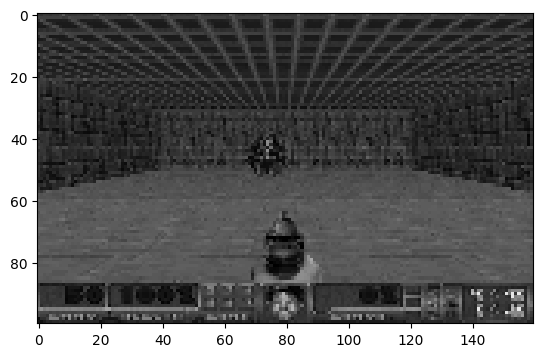

In [29]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

### this is the grayscale image

In [61]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [62]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [63]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [65]:
env=VizDoomGym()

In [66]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [69]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31       |
|    ep_rew_mean     | -75.3    |
| time/              |          |
|    fps             | 82       |
|    iterations      | 1        |
|    time_elapsed    | 24       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.9        |
|    ep_rew_mean          | -58.8       |
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 2           |
|    time_elapsed         | 50          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008114276 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.000324  

### Testing

In [71]:
model=PPO.load("./train/train_basic/best_model_90000")

In [72]:
env=VizDoomGym(render=True)

In [77]:
env = Monitor(env)
mean_reward,_=evaluate_policy(model,env,n_eval_episodes=100)

In [78]:
mean_reward

86.24

In [81]:
env.close()

In [5]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_basic/best_model_90000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 10


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        # time.sleep(0.20)
        total_reward += reward
        done=terminated or truncated
        time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 71.0
Episode 2: Total Reward = 83.0
Episode 3: Total Reward = 87.0
Episode 4: Total Reward = 95.0
Episode 5: Total Reward = 95.0
Episode 6: Total Reward = 95.0
Episode 7: Total Reward = 67.0
Episode 8: Total Reward = 95.0
Episode 9: Total Reward = 67.0
Episode 10: Total Reward = 71.0
